In [1]:
from huggingface_hub import snapshot_download


def pull_from_hf_model_hub(specifier, version=None, cache_dir=None):
    return snapshot_download(
        specifier,
        revision=version,
        cache_dir=cache_dir,
    )

In [2]:
import logging
import os

import numpy as np
import torch

logger = logging.getLogger(__name__)

SFT_FILE_NAME = 'pytorch_diff.bin'


def encode_sparse_tensor(tensor):
    """
    Compresses a sparse tensor by flattening indices into a single dimension to
    reduce size of saved SFTs.
    """
    multipliers = np.cumprod([1] + list(tensor.size())[:-1], dtype=np.int64)
    coordinates = np.array(tensor.indices().to('cpu'), dtype=np.int64)
    indices = np.matmul(multipliers, coordinates)
    perm = list(range(len(indices)))
    perm.sort(key=lambda x: indices[x])
    indices = indices[perm]
    index_steps = indices[1:] - indices[:-1]
    index_steps = index_steps.tolist()
    if len(indices) > 0:
        index_steps = [indices[0]] + index_steps
    values = tensor.values().to('cpu')[perm]
    return {
        'size': tensor.size(),
        'index_steps': index_steps,
        'values': values,
    }


def decode_sparse_tensor(encoding):
    """
    Inverse of encode_sparse_tensor.
    """
    size = encoding['size']
    index_steps = encoding['index_steps']
    values = encoding['values']

    indices = np.cumsum(index_steps, dtype=np.int32)
    modulos = np.cumprod(list(size), dtype=np.int32)
    divisors = np.concatenate([[1], modulos[:-1]], dtype=np.int32)

    coordinates = np.expand_dims(indices, 0) // np.expand_dims(divisors, 1)
    coordinates = coordinates % np.expand_dims(modulos, 1)

    return torch.sparse_coo_tensor(coordinates, values, size=size).coalesce()


class SFT:
    """
    Represents a sparse fine-tuning of a pre-trained base model. Contains two
    sets of tensors, "diffs", the difference tensors for sparsely fine-tuned
    parameters, and "abs", the fully-specified values of fully fine-tuned
    parameters, e.g. model head parameters.

    Args:
        name_or_path: if supplied, specifies where to load the SFT from. If
        a valid directory path, the SFT is loaded from the local file system,
        otherwise, will attempt to load a SFT of the given name from huggingface
        models. If not supplied, an empty SFT will be created.
        version: version number on huggingface models.
        cache_dir: huggingface cache directory.
    """
    def __init__(self,
        name_or_path=None,
        version=None,
        cache_dir=None,
    ):
        if name_or_path is not None:
            if os.path.isdir(name_or_path):
                sft_dir = name_or_path
            else:
                sft_dir = pull_from_hf_model_hub(
                    name_or_path,
                    version=version,
                    cache_dir=cache_dir
                )

            sft_file = os.path.join(sft_dir, SFT_FILE_NAME)
            tensors = torch.load(sft_file)

            if 'diffs' in tensors:
                self.diffs = {
                    p: decode_sparse_tensor(d)
                    for p, d in tensors['diffs'].items()
                }
            else:
                self.diffs = {}

            if 'abs' in tensors:
                self.abs = tensors['abs']
            else:
                self.abs = {}

            if not self.diffs and not self.abs:
                logger.warn(f'Empty SFT {name_or_path}')
        else:
            self.diffs = {}
            self.abs = {}

    def add_param(self, name, tensor, diff=True):
        """
        Adds a new parameter tensor to the SFT.

        Args:
            name: the parameter name, e.g. bert.embeddings.word_embeddings.weight.
            tensor: the tensor of differences/values.
            diff: bool, if true the tensor contains the differences between the
            fine-tuned and original parameter values, otherwise it contains
            fully-specified dense values (i.e. an "abs" parameter).
        """
        if diff:
            self.diffs[name] = tensor.to_sparse().coalesce()
        else:
            self.abs[name] = tensor.to('cpu')

    def save(self, save_dir):
        encoded_diffs = {
            n: encode_sparse_tensor(p)
            for n, p in self.diffs.items()
        }
        tensors = {
            'diffs': encoded_diffs,
            'abs': self.abs,
        }
        save_path = os.path.join(save_dir, SFT_FILE_NAME)
        torch.save(tensors, save_path)

    def apply(self, model, with_abs=True):
        """
        Applies SFT to a model by adding the sparse parameter differences to the
        model's parameters, and setting the value of the "abs" parameters to the
        SFT's values if with_abs is True.

        Args:
            model: an nn.Module, the model.
            with_abs: determines whether the SFT's "abs" parameters are applied.
            This should be False when applying a language SFT to a task-oriented
            model such as ...ModelForTokenClassification, because otherwise a
            crash will occur when the SFT tries to copy the values of the
            language modelling head parameters to the task model which lacks
            these parameters.
        """
        with torch.no_grad():
            for name in self.diffs.keys():
                diff = self.diffs[name]
                tensor = model.get_parameter(name)
                if diff.device != tensor.device:
                    # Permanently copy the diff tensor to the parameter tensor's
                    # device so that future applications and reversions can
                    # be carried out faster. This is important for good
                    # performance in multi-source training.
                    diff = diff.to(tensor.device)
                    self.diffs[name] = diff
                tensor += diff

            if with_abs:
                for name, value in self.abs.items():
                    tensor = model.get_parameter(name)
                    tensor.copy_(value)

    def revert(self, model):
        """
        Removes SFT from a model by subtracting the sparse parameter
        differences.
        """
        with torch.no_grad():
            for name in self.diffs.keys():
                diff = self.diffs[name]
                tensor = model.get_parameter(name)
                if diff.device != tensor.device:
                    diff = diff.to(tensor.device)
                    self.diffs[name] = diff
                tensor -= diff



In [3]:
lang_ft = "cambridgeltl/xlmr-lang-sft-gn-small"
gn_sft = SFT(lang_ft)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_diff.bin:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

<ipython-input-2-ed9a42caaabe>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(sft_file)


In [4]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
model_name_or_path = "xlm-roberta-base"
num_labels = 3

In [6]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    finetuning_task="nli",
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [7]:

model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Assuming `sft` is the SFT instance that was loaded previously
def layer_by_layer_analysis(model, sft):
    """
    Performs a layer-by-layer analysis of the model to determine how many parameters
    have been modified by the SFT in each layer.

    Args:
        model: The original pre-trained model.
        sft: The SFT instance containing the sparse fine-tuning deltas.
    """
    # To keep track of parameters per layer
    total_params_per_layer = {}
    modified_params_per_layer = {}

    # Step 1: Count the total number of parameters for each layer
    for name, param in model.named_parameters():
        # Extract the base layer name (e.g., `bert.encoder.layer.0` from `bert.encoder.layer.0.attention.self.query.weight`)
        layer_name = '.'.join(name.split('.')[:-1])

        # Initialize the count if encountering the layer for the first time
        if layer_name not in total_params_per_layer:
            total_params_per_layer[layer_name] = 0
        total_params_per_layer[layer_name] += param.numel()

    # Step 2: Count the number of modified parameters for each layer from `sft.diffs`
    for param_name, diff_tensor in sft.diffs.items():
        # Extract the base layer name
        layer_name = '.'.join(param_name.split('.')[:-1])

        # Initialize the count if encountering the layer for the first time
        if layer_name not in modified_params_per_layer:
            modified_params_per_layer[layer_name] = 0
        modified_params_per_layer[layer_name] += diff_tensor._nnz()  # Only count non-zero entries (sparsity)

    # Step 3: Print out the layer-by-layer analysis
    print("Layer-by-Layer Parameter Analysis:")
    for layer_name in total_params_per_layer:
        total_params = total_params_per_layer[layer_name]
        modified_params = modified_params_per_layer.get(layer_name, 0)
        percentage_modified = (modified_params / total_params) * 100 if total_params > 0 else 0
        print(f"Layer: {layer_name}")
        print(f"  Total Parameters: {total_params}")
        print(f"  Modified Parameters in SFT: {modified_params}")
        print(f"  Percentage Modified: {percentage_modified:.2f}%")
        print()

In [ ]:
layer_by_layer_analysis(model, gn_sft)

Layer-by-Layer Parameter Analysis:
Layer: roberta.embeddings.word_embeddings
  Total Parameters: 192001536
  Modified Parameters in SFT: 1492884
  Percentage Modified: 0.78%

Layer: roberta.embeddings.position_embeddings
  Total Parameters: 394752
  Modified Parameters in SFT: 14385
  Percentage Modified: 3.64%

Layer: roberta.embeddings.token_type_embeddings
  Total Parameters: 768
  Modified Parameters in SFT: 96
  Percentage Modified: 12.50%

Layer: roberta.embeddings.LayerNorm
  Total Parameters: 1536
  Modified Parameters in SFT: 0
  Percentage Modified: 0.00%

Layer: roberta.encoder.layer.0.attention.self.query
  Total Parameters: 590592
  Modified Parameters in SFT: 31556
  Percentage Modified: 5.34%

Layer: roberta.encoder.layer.0.attention.self.key
  Total Parameters: 590592
  Modified Parameters in SFT: 36583
  Percentage Modified: 6.19%

Layer: roberta.encoder.layer.0.attention.self.value
  Total Parameters: 590592
  Modified Parameters in SFT: 14645
  Percentage Modified: 2

#Generate histogram for the distribution of SFT params

In [10]:
import matplotlib.pyplot as plt

def plot_total_parameters(model, model_name="Model"):
    """
    Creates a histogram for the total number of parameters per group (embeddings, numbered layers).

    Args:
        model: The original pre-trained model.
        model_name: Optional; the name of the model to display on the plot.
    """
    total_params_per_group = {
        'Embeddings': 0,
        'Numbered Layers': {}
    }

    # Step 1: Count the total number of parameters for each group
    for name, param in model.named_parameters():
        if name.startswith("roberta.embeddings"):
            # Embedding parameters
            total_params_per_group['Embeddings'] += param.numel()
        elif "encoder.layer" in name:
            # Numbered layers parameters
            parts = name.split('.')
            layer_index = int(parts[parts.index('layer') + 1])
            if layer_index not in total_params_per_group['Numbered Layers']:
                total_params_per_group['Numbered Layers'][layer_index] = 0
            total_params_per_group['Numbered Layers'][layer_index] += param.numel()

    # Prepare data for plotting
    groups = ['Embeddings'] + list(sorted(total_params_per_group['Numbered Layers'].keys()))
    total_params = [total_params_per_group['Embeddings']] + \
                   [total_params_per_group['Numbered Layers'][layer] for layer in sorted(total_params_per_group['Numbered Layers'])]

    # Convert numbered layers to string labels for display
    group_labels = ['Embeddings'] + [f'Layer {layer}' for layer in sorted(total_params_per_group['Numbered Layers'])]

    # Create the histogram for total parameters
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(groups)), total_params, color='blue', alpha=0.7)
    plt.xlabel('Layer Group')
    plt.ylabel('Number of Parameters')
    plt.title(f'Total Parameters per group for {model_name}')
    plt.xticks(range(len(groups)), group_labels, rotation=90)
    plt.tight_layout()
    plt.show()


def plot_modified_parameters(sft, model_name="Model"):
    """
    Creates a histogram for the modified parameters in the SFT, including embeddings.

    Args:
        sft: The SFT instance containing the sparse fine-tuning deltas.
        model_name: Optional; the name of the model to display on the plot.
    """
    modified_params_per_group = {
        'Embeddings': 0,
        'Numbered Layers': {}
    }

    # Step 2: Count the number of modified parameters for each group from `sft.diffs`
    for param_name, diff_tensor in sft.diffs.items():
        if param_name.startswith("roberta.embeddings"):
            # Embedding parameters
            modified_params_per_group['Embeddings'] += diff_tensor._nnz()
        elif "encoder.layer" in param_name:
            # Numbered layers parameters
            parts = param_name.split('.')
            layer_index = int(parts[parts.index('layer') + 1])
            if layer_index not in modified_params_per_group['Numbered Layers']:
                modified_params_per_group['Numbered Layers'][layer_index] = 0
            modified_params_per_group['Numbered Layers'][layer_index] += diff_tensor._nnz()

    # Prepare data for plotting
    groups = ['Embeddings'] + list(sorted(modified_params_per_group['Numbered Layers'].keys()))
    modified_params = [modified_params_per_group['Embeddings']] + \
                      [modified_params_per_group['Numbered Layers'].get(layer, 0) for layer in sorted(modified_params_per_group['Numbered Layers'])]

    # Convert numbered layers to string labels for display
    group_labels = ['Embeddings'] + [f'Layer {layer}' for layer in sorted(modified_params_per_group['Numbered Layers'])]

    # Create the histogram for modified parameters
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(groups)), modified_params, color='red', alpha=0.7)
    plt.xlabel('Layer Group')
    plt.ylabel('Number of Modified Parameters')
    plt.title(f'Modified Parameters per group for {model_name} SFT')
    plt.xticks(range(len(groups)), group_labels, rotation=90)
    plt.tight_layout()
    plt.show()

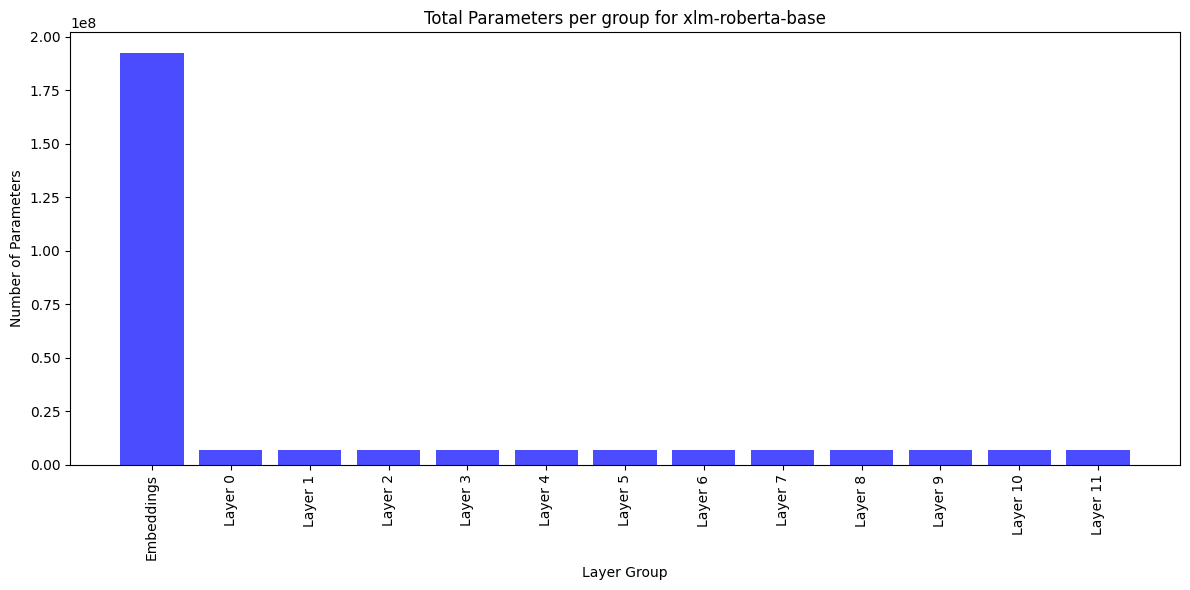

In [11]:
plot_total_parameters(model, "xlm-roberta-base")

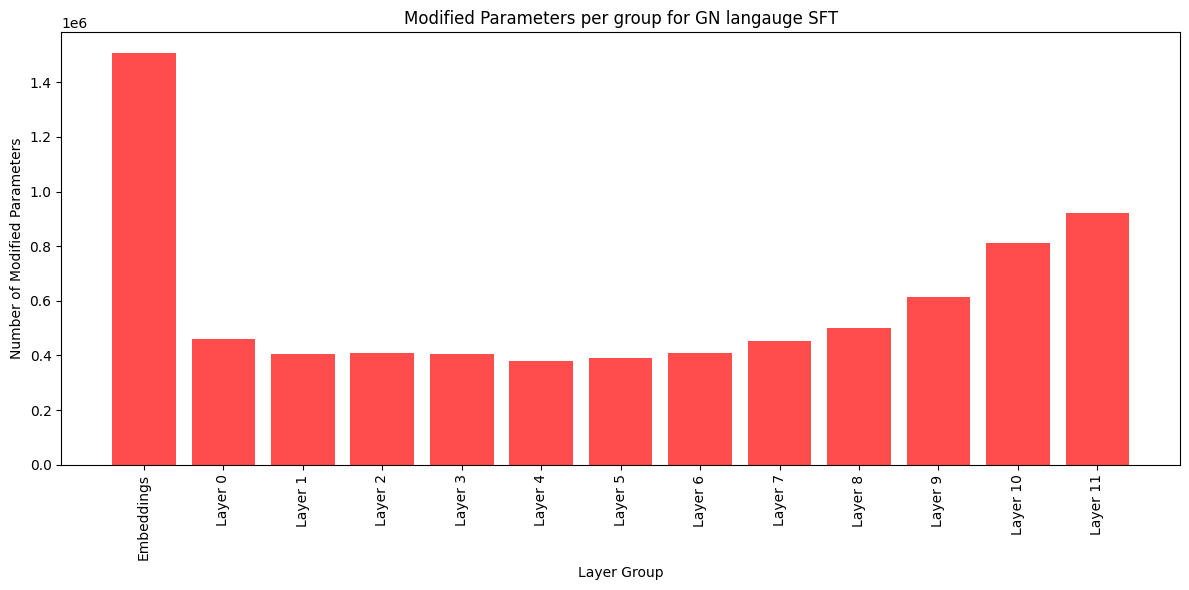

In [12]:
plot_modified_parameters(gn_sft, "GN langauge")

In [13]:
aym_sft = SFT("cambridgeltl/xlmr-lang-sft-aym-small")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_diff.bin:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

<ipython-input-2-ed9a42caaabe>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(sft_file)


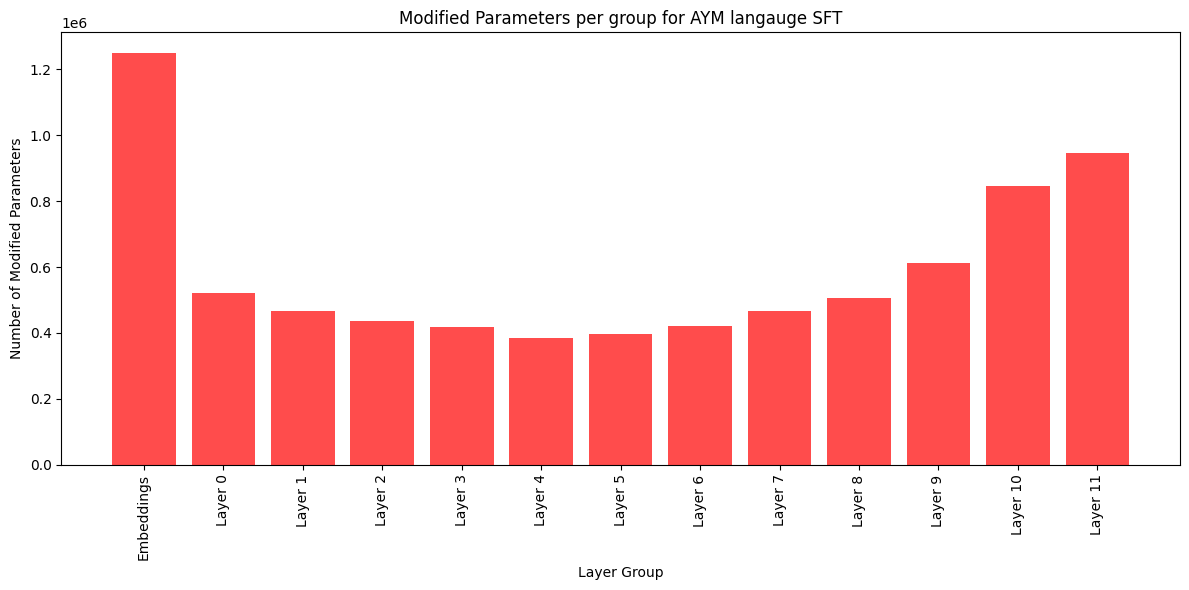

In [14]:
plot_modified_parameters(aym_sft, "AYM langauge")

In [15]:
nli_sft = SFT("cambridgeltl/xlmr-task-sft-nli")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_diff.bin:   0%|          | 0.00/87.6M [00:00<?, ?B/s]

<ipython-input-2-ed9a42caaabe>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(sft_file)


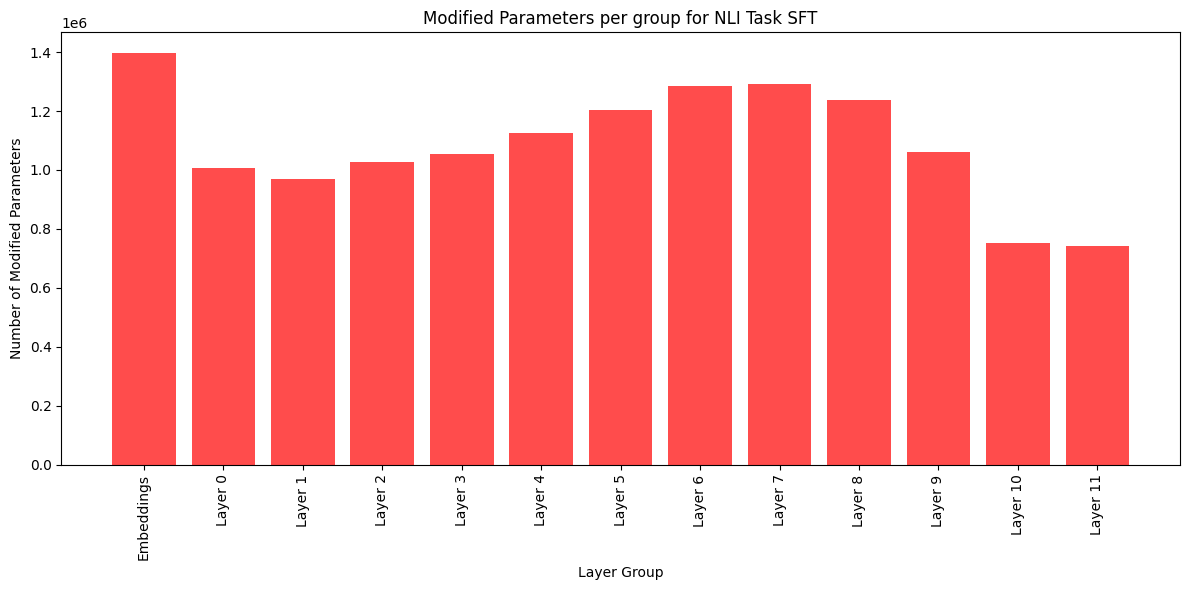

In [16]:
plot_modified_parameters(nli_sft, "NLI Task")

In [17]:
sa_sft = SFT("cambridgeltl/xlmr-task-sft-nusax_senti")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

pytorch_diff.bin:   0%|          | 0.00/87.5M [00:00<?, ?B/s]

<ipython-input-2-ed9a42caaabe>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(sft_file)


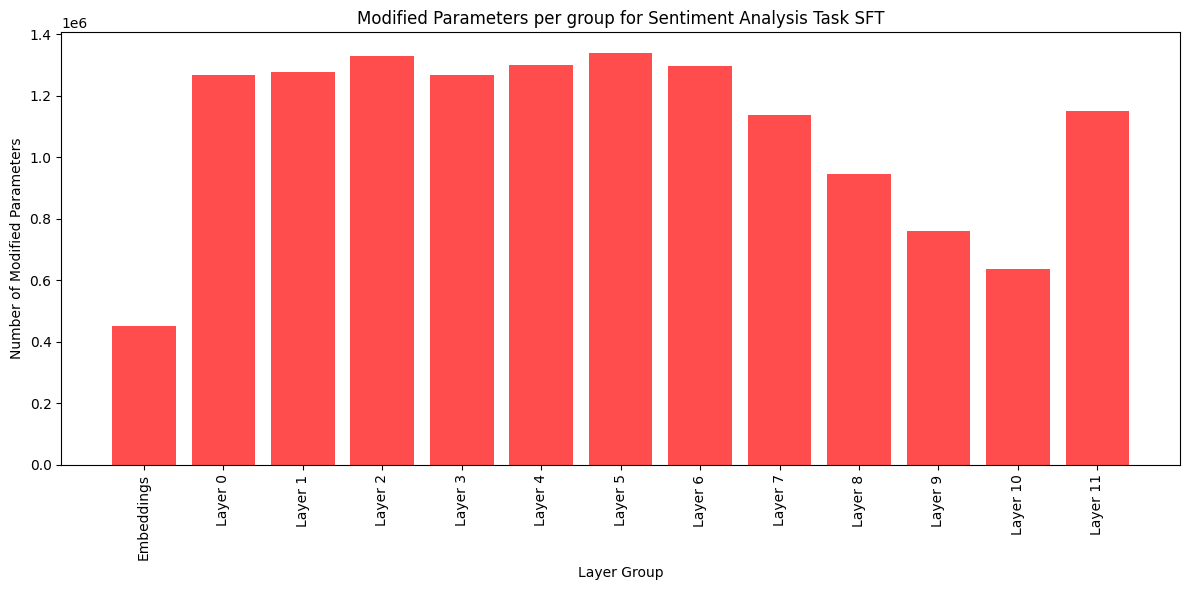

In [18]:
plot_modified_parameters(sa_sft, "Sentiment Analysis Task")

In [ ]:
sum([vals._nnz() for vals in nli_sft.diffs.values()] + [vals.numel() for vals in nli_sft.abs.values()])

14748682

In [ ]:
sum([vals._nnz() for vals in gn_sft.diffs.values()] + [vals.numel() for vals in gn_sft.abs.values()])

8509841